# Big Data Project -Spring 2020
### Dataset: 
#### Craigslist UsedCars Data
Data Set was found here:
https://www.kaggle.com/austinreese/craigslist-carstrucks-data
Download "vehicles.csv" file from this link. 

### Description
In this project, Cleaning the data first, Preprocessing data,Exploratory Data Analysis of missing data, Visualizing the data and predicting the selling price of a used car based on reported trends. 

### Goal
Observing the different patterns of how selling price of cars is dependent on various features and predicting the price of used cars using Supervised Machine Learning Models with Scikit Learn Library and Pyspark ML Library. 

In this Project we are using different Supervised Regression Models to predict the price.

### Observations
In the original data when we performed EDA we found there are few columns which are not contributing towards price prediction so we dropped them.
There is also significant amount of Missing values in few columns, we approached the problem in two ways
1. Dropped all the missing values from the data.
2. Filled the missing data in categorical columns with ‘Unknown’ category and numerical columns with mean values.


### Libraries Used: Scikit Learn, Pyspark ML , plotly 
Plotly Installation pip command: pip install plotly==4.7.1


In [1]:
# Importing the required libraries 
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import plotly.express as px

In [3]:
# File importing 
vehicles_data = pd.read_csv("./vehicles.csv")
vehicles_data.describe(include='all')

id                                                url  \
count   5.397590e+05                                             539759   
unique           NaN                                             539759   
top              NaN  https://stlouis.craigslist.org/cto/d/arnold-gr...   
freq             NaN                                                  1   
mean    7.087609e+09                                                NaN   
std     5.234176e+06                                                NaN   
min     7.065765e+09                                                NaN   
25%     7.084240e+09                                                NaN   
50%     7.088973e+09                                                NaN   
75%     7.092094e+09                                                NaN   
max     7.093537e+09                                                NaN   

              region                   region_url         price  \
count         539759                       539759  5.397590e+05   
unique           403                          413           NaN   
top     fayetteville  https://york.craigslist.org           NaN   
freq            4131                         2995           NaN   
mean             NaN                          NaN  1.954214e+05   
std              NaN                          NaN  2.208252e+07   
min              NaN                          NaN  0.000000e+00   
25%              NaN                          NaN  4.400000e+03   
50%              NaN                          NaN  9.500000e+03   
75%              NaN                          NaN  1.792600e+04   
max              NaN                          NaN  4.294967e+09   

                 year manufacturer   model  condition    cylinders  ...  \
count   538772.000000       516175  531746     303707       321264  ...   
unique            NaN           43   36948          6            8  ...   
top               NaN         ford   f-150  excellent  6 cylinders  ...   
freq              NaN        98858   11630     142619       116713  ...   
mean      2009.830982          NaN     NaN        NaN          NaN  ...   
std          9.161334          NaN     NaN        NaN          NaN  ...   
min          0.000000          NaN     NaN        NaN          NaN  ...   
25%       2007.000000          NaN     NaN        NaN          NaN  ...   
50%       2012.000000          NaN     NaN        NaN          NaN  ...   
75%       2015.000000          NaN     NaN        NaN          NaN  ...   
max       2021.000000          NaN     NaN        NaN          NaN  ...   

         drive       size    type paint_color  \
count   383987     168550  392290      365520   
unique       3          4      13          12   
top        4wd  full-size   sedan       white   
freq    178592      92545   96119       95528   
mean       NaN        NaN     NaN         NaN   
std        NaN        NaN     NaN         NaN   
min        NaN        NaN     NaN         NaN   
25%        NaN        NaN     NaN         NaN   
50%        NaN        NaN     NaN         NaN   
75%        NaN        NaN     NaN         NaN   
max        NaN        NaN     NaN         NaN   

                                                image_url  \
count                                              539740   
unique                                             364282   
top     https://images.craigslist.org/00x0x_lrea3FJu7R...   
freq                                                  191   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                              description county   state  \
count        

## Data Cleaning

In [4]:
# Removing the columns which are least contributing to the "Price" prediction
dropcolumns = ['url','region_url','vin','county','id','lat','long','region','state','image_url','description']
vehicles_data = vehicles_data.drop(dropcolumns, axis=1)
vehicles_data.shape

(539759, 14)

count    5.397590e+05
mean     1.954214e+05
std      2.208252e+07
min      0.000000e+00
25%      4.400000e+03
50%      9.500000e+03
75%      1.792600e+04
max      4.294967e+09
Name: price, dtype: float64

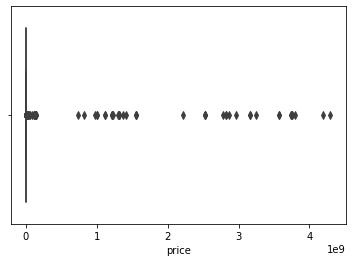

In [5]:
# Visualize "price" column outliers in original vehicle data 
sns.boxplot(vehicles_data.price)
vehicles_data.price.describe()

Text(0, 0.5, 'Count')

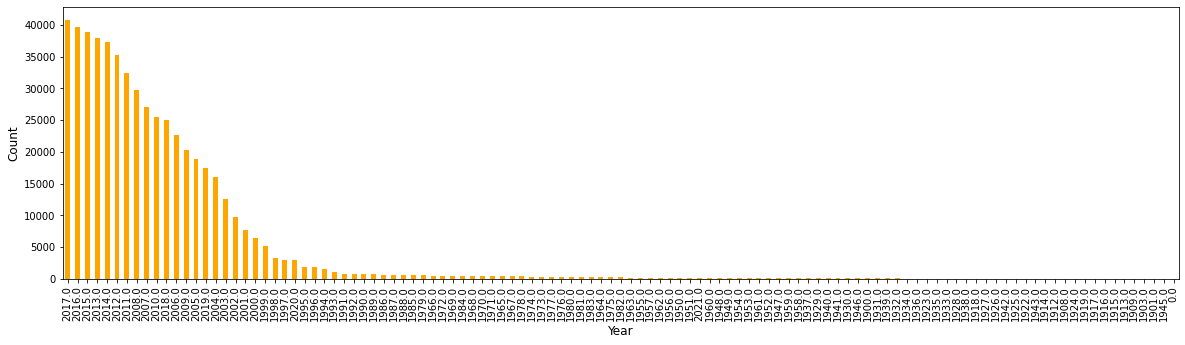

In [6]:
# Visualize "year" column values in original vehicle data
plt.figure(figsize =(20,5))
vehicles_data['year'].value_counts().plot(kind='bar',color='orange')
plt.xlabel("Year",fontsize=12)
plt.ylabel("Count",fontsize=12)

##### We want to observe the price trends from 1991 to 2019 and also in the most common price range, so we filtered our data accordingly.

In [7]:
# Filter out data for "price" and "year" columns in given range
vehicles_data = vehicles_data[(vehicles_data['year'] > 1990) & (vehicles_data['year'] < 2020 ) & (vehicles_data['price'] <= 100000)& (vehicles_data['price'] > 100)  ]
vehicles_data.shape

(472784, 14)

##### Age is one of the prominent feature in predicting the price, so we calculated age in new 'age' column by using 'year' column  and then dropped 'year' column

In [8]:
# Find age of vehicle. Add new "age" column and removing "year" column 
from datetime import datetime

current_year = datetime.now().year
vehicles_data['age'] = current_year - vehicles_data['year']
del vehicles_data['year']


In [9]:
# Dropping duplicate rows from data
vehicles_data.drop_duplicates(keep='first',inplace=True)
vehicles_data.shape

(334594, 14)

##### Separating the numerical and categorical columns

In [10]:
# Finding datatypes of all columns and splitting column names into two lists
categorical_data = []
numerical_data = []
def find_dtypes(df):
    ''' Categorizes columns as either Numerical Column or Categorical Column depending on its datatype
        i.e If datatype is object , it is added into Categorical data list else in Numerical data list. '''
    for col in df.columns.tolist():
        if df[col].dtype=='object':
            categorical_data.append(col)
        else:
            numerical_data.append(col)
    categorical_col = pd.Series(categorical_data, name='Categorical Columns')
    numerical_col = pd.Series(numerical_data, name='Numerical Columns')
    df_dtypes = pd.concat([categorical_col,numerical_col], axis=1)
    return df_dtypes

In [11]:
# Find out columns in vehicles data as either Categorical or Numerical
find_dtypes(vehicles_data)

Categorical Columns Numerical Columns
0         manufacturer             price
1                model          odometer
2            condition               age
3            cylinders               NaN
4                 fuel               NaN
5         title_status               NaN
6         transmission               NaN
7                drive               NaN
8                 size               NaN
9                 type               NaN
10         paint_color               NaN

In [12]:
# Print unique values in each column in vehicles data
for col in vehicles_data.columns:
    unique_columns = vehicles_data[col].nunique()
    print(" The unique values in the '{col}' are {unique_columns} ".format(col=col, unique_columns=unique_columns))

 The unique values in the 'price' are 17558 
 The unique values in the 'manufacturer' are 41 
 The unique values in the 'model' are 31813 
 The unique values in the 'condition' are 6 
 The unique values in the 'cylinders' are 8 
 The unique values in the 'fuel' are 5 
 The unique values in the 'odometer' are 114489 
 The unique values in the 'title_status' are 6 
 The unique values in the 'transmission' are 3 
 The unique values in the 'drive' are 3 
 The unique values in the 'size' are 4 
 The unique values in the 'type' are 13 
 The unique values in the 'paint_color' are 12 
 The unique values in the 'age' are 29 


In [13]:
# Print count of null values in each column in vehicles data
for col in vehicles_data.columns:
    null_values = vehicles_data[col].isnull().sum()
    print("Total null values in the '{col}' are {null_values} ".format(col=col, null_values=null_values))

Total null values in the 'price' are 0 
Total null values in the 'manufacturer' are 11971 
Total null values in the 'model' are 4152 
Total null values in the 'condition' are 132878 
Total null values in the 'cylinders' are 124403 
Total null values in the 'fuel' are 1889 
Total null values in the 'odometer' are 60166 
Total null values in the 'title_status' are 1352 
Total null values in the 'transmission' are 2014 
Total null values in the 'drive' are 94254 
Total null values in the 'size' are 217725 
Total null values in the 'type' are 94292 
Total null values in the 'paint_color' are 102308 
Total null values in the 'age' are 0 


##### We observe that there is significant amount of missing data in few columns and we analyze it by percentage values

In [14]:
#Function to check the percentage of missing data
def check_missing_data(df):
    ''' Returns dataframe having two columns each containing total count of missing data and percent of missing
        data for all columns in given data'''
    missing_df_data = df.isnull().sum().sort_values(ascending = False)
    percent_missing_data = (df.isnull().sum()/len(df)*100).sort_values(ascending = False)
    missing_data  = pd.concat([missing_df_data, percent_missing_data], axis=1, 
                              keys=['Total_Missing_data', 'Percent(%)'])
    
    return missing_data

In [15]:
# Find out percent of total missing data for each column in vehicles data
check_missing_data(vehicles_data)

Total_Missing_data  Percent(%)
size                      217725   65.071400
condition                 132878   39.713205
cylinders                 124403   37.180284
paint_color               102308   30.576759
type                       94292   28.181019
drive                      94254   28.169662
odometer                   60166   17.981793
manufacturer               11971    3.577769
model                       4152    1.240907
transmission                2014    0.601924
fuel                        1889    0.564565
title_status                1352    0.404072
age                            0    0.000000
price                          0    0.000000

#### Following two approaches in dealing with missing values :-
* Dropping all the NaN values present in data
* Replacing Nan with 'Unknown' as a value for Categorical columns and with mean value for Numerical columns

In [16]:
# Copying so far cleaned vehicles data into two different dataframes for the purpose of preprocessing.

# Used for the purpose of dropping missing or nan values from columns
dropped_null_vehicles_data = vehicles_data.copy()

# Used for the purpose of replacing missing or nan values with another value
replaced_null_vehicles_data = vehicles_data.copy()


In [17]:
# Dropping all missing or nan values from vehicles data 
dropped_null_vehicles_data=dropped_null_vehicles_data.dropna(axis = 0)

In [18]:
print(dropped_null_vehicles_data.shape)
print(replaced_null_vehicles_data.shape)

(77629, 14)
(334594, 14)


In [19]:
# Check percentage of missing data from columns before replacing them by using "check_missing_data" function
check_missing_data(replaced_null_vehicles_data)


Total_Missing_data  Percent(%)
size                      217725   65.071400
condition                 132878   39.713205
cylinders                 124403   37.180284
paint_color               102308   30.576759
type                       94292   28.181019
drive                      94254   28.169662
odometer                   60166   17.981793
manufacturer               11971    3.577769
model                       4152    1.240907
transmission                2014    0.601924
fuel                        1889    0.564565
title_status                1352    0.404072
age                            0    0.000000
price                          0    0.000000

In [20]:
# Function to deal missing data
def fill_missing(df1, varlist = None , vartype = None ):
    '''Fills missing/zero values in given dataframe with another value or categorical value '''
    
    # filling numerical data with mean
    if vartype == 'numerical' :
        for col in varlist:
            df1[col] = df1[col].fillna(df1[col].mean())
    
    # filling categorical data with unknown
    if vartype == 'categorical' :
        for col in varlist:
            df1[col] = df1[col].fillna("Unknown")

In [21]:
# First,check datatype of columns and split into two categories.Then,fill null values accordingly for each category
categorical_data = []
numerical_data= []

find_dtypes(replaced_null_vehicles_data)

fill_missing(replaced_null_vehicles_data, numerical_data, 'numerical')
fill_missing(replaced_null_vehicles_data, categorical_data, 'categorical')

check_missing_data(replaced_null_vehicles_data)

Total_Missing_data  Percent(%)
age                            0         0.0
paint_color                    0         0.0
type                           0         0.0
size                           0         0.0
drive                          0         0.0
transmission                   0         0.0
title_status                   0         0.0
odometer                       0         0.0
fuel                           0         0.0
cylinders                      0         0.0
condition                      0         0.0
model                          0         0.0
manufacturer                   0         0.0
price                          0         0.0

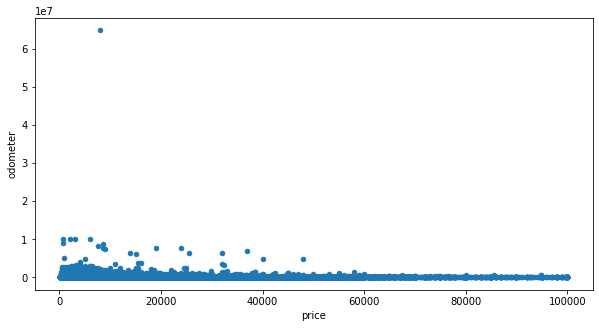

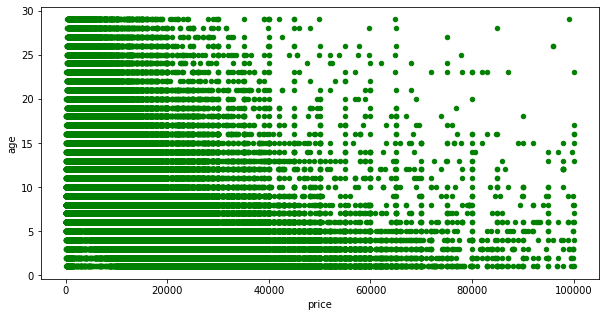

In [22]:
# Observing the Outliers in the Numerical Columns in Replaced Data

replaced_null_vehicles_data.plot(kind='scatter',x='price',y='odometer',figsize=(10,5))
replaced_null_vehicles_data.plot(kind='scatter',y='age',x='price',color='green',figsize=(10,5))


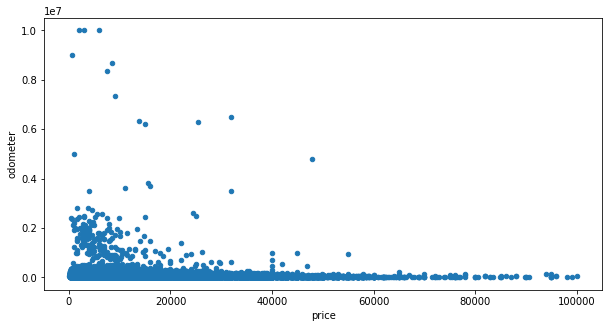

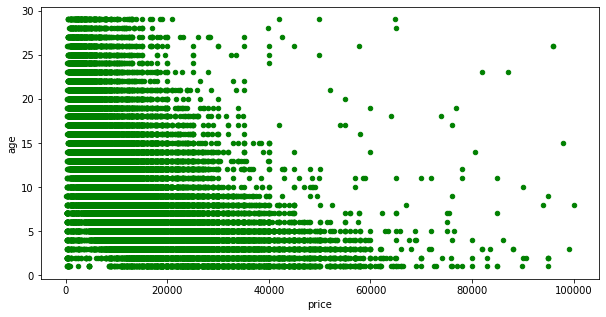

In [23]:
# Observing the Outliers in the Numerical Columns in Dropped Data

dropped_null_vehicles_data.plot(kind='scatter',x='price',y='odometer',figsize=(10,5))
dropped_null_vehicles_data.plot(kind='scatter',y='age',x='price',color='green',figsize=(10,5))

In [24]:
#Removing outliers using z score method

from scipy import stats
import numpy as np

threshold = 3

z_score_replace = np.abs(stats.zscore(replaced_null_vehicles_data._get_numeric_data()))
replaced_null_vehicles_data = replaced_null_vehicles_data[(z_score_replace < threshold).all(axis=1)]

z_score_drop = np.abs(stats.zscore(dropped_null_vehicles_data._get_numeric_data()))
dropped_null_vehicles_data = dropped_null_vehicles_data[(z_score_drop < threshold).all(axis=1)]




In [25]:
dropped_null_vehicles_data.shape

(75602, 14)

In [26]:
replaced_null_vehicles_data.shape

(327122, 14)

## Data Visualization

### 1.) Box plot & Distribution plot for 'price' column

In [142]:
#Function to plot the Distribution and Box plots
def price_plot(df):
    '''Box plot and distribution plot for 'price' column '''
    plt.figure(figsize=(20,5))
    plt.subplot(1, 2, 1)
    sns.boxplot(df.price,color='purple')
    plt.title('Box Plot')

    plt.subplot(1, 2, 2)
    sns.distplot(df['price'],color='maroon',kde=False, bins=50)
    plt.title('Histogram')
    plt.show()
    
    plt.subplot(2, 1, 1)
    sns.distplot(df['price'],color='blue', hist=False,bins=50)
    plt.title('Kernel Density Estimate')
    plt.show()

#### 1.1) With Replaced null data

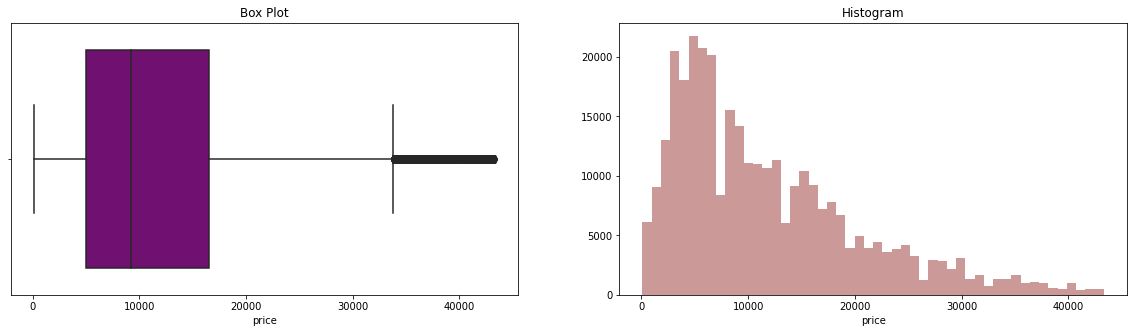

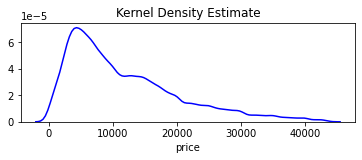

In [143]:
price_plot(replaced_null_vehicles_data)

##### Observation: The median price is around 10,000 and the most listings of cars are in the price range of 3000 to 18000.

#### 1.2) With Dropped null data

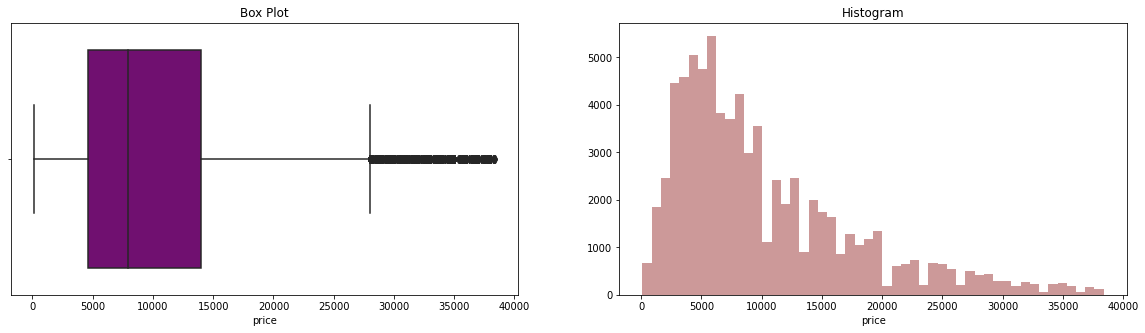

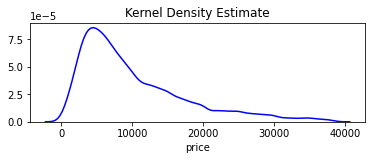

In [144]:
price_plot(dropped_null_vehicles_data)

##### Observation: The median price is around 8000 and the most listings of cars are in the price range 3000 to 12000

### 2.) Plot Average price value of each condition type of vehicle

In [86]:
def condition_with_max_price(df):
    ''' Plot Average price value of every condition'''
        
    price = df.groupby('condition')['price'].mean().reset_index()
    price = price.sort_values("price",ascending=False)
    fig = px.pie(price,
                 values="price",
                 names="condition",
                 template="seaborn", title='Average Percent of price by condition')
    fig.update_traces(textinfo="percent+label")
    fig.update_layout(autosize=False,width=500,height=500)
    fig.show()



#### 2.1) With Replaced null data
##### Note: We are attaching screenshot of output piechart in markdown. You can run the code by installing the ploty library to see the result.

In [87]:
condition_with_max_price(replaced_null_vehicles_data)

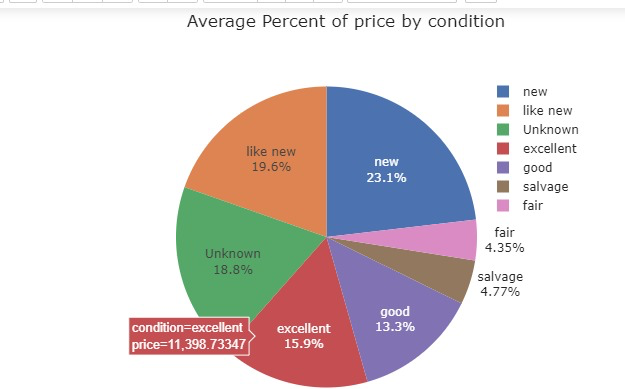

##### Observation: We can observe that average price of a car whose condition is new is the most followed by like new

#### 2.2) With Dropped null data
##### Note: We are attaching screenshot of output piechart in markdown. You can run the code by installing the ploty library to see the result.

In [88]:
condition_with_max_price(dropped_null_vehicles_data)


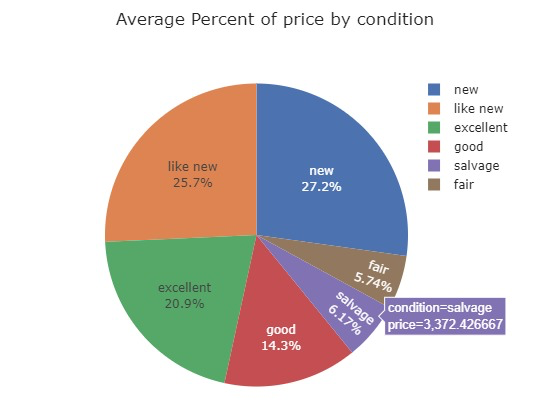

##### Observation:With dropped data also, average price of a car whose condition is new is the most followed by like new 

### 3.)  Plot number of listings of every manufacturer

In [89]:
def manufacturer_listing(df):    
    plt.figure(figsize=(10,6))
    manufacturer_count = df['manufacturer'].value_counts().head(10)
    ax= sns.barplot(manufacturer_count.index,manufacturer_count.values,palette='autumn')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right",fontsize=8)
    plt.title("Manufacturers vs no. of listings")
    plt.xlabel("Manufacturer")
    plt.ylabel("Count")
    plt.show()

#### 3.1) With Replaced null data

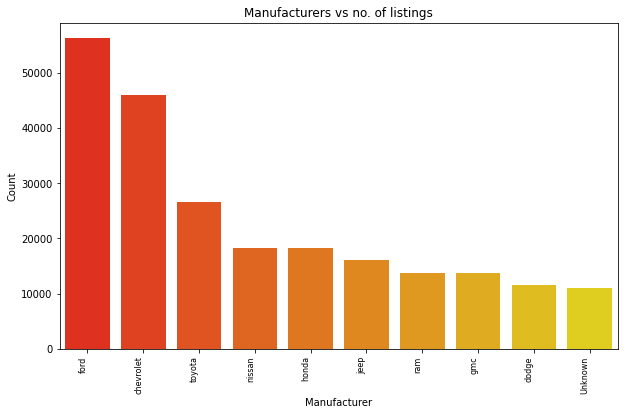

In [90]:
manufacturer_listing(replaced_null_vehicles_data)



#### 3.2) With Dropped null data

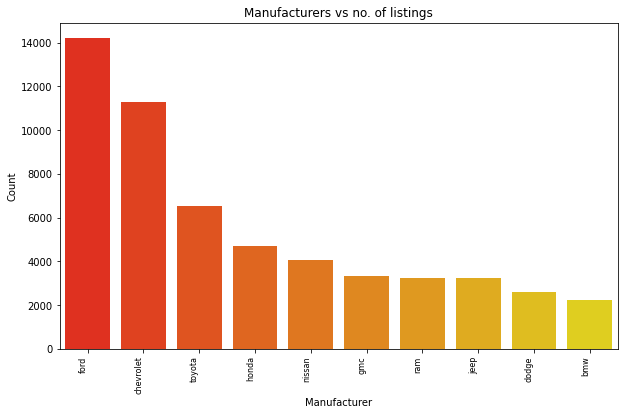

In [91]:
manufacturer_listing(dropped_null_vehicles_data)

##### Observation: The top10 car manufacturer listings. We can observe a difference in the count and brands of the manufacturers

### 4.) Plot popular paint-color of vehicles

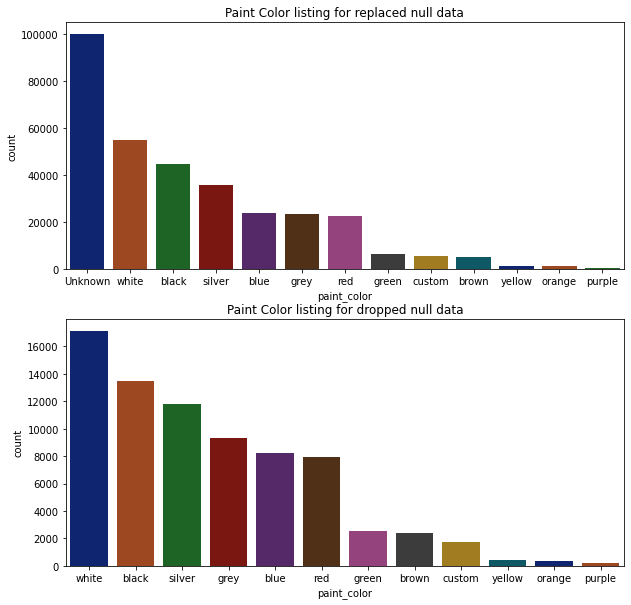

In [92]:
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
sns.countplot(x = replaced_null_vehicles_data['paint_color'], order = replaced_null_vehicles_data['paint_color'].value_counts().index,
              data = replaced_null_vehicles_data,palette="dark")
plt.title('Paint Color listing for replaced null data')


plt.subplot(2, 1, 2)
sns.countplot(x = dropped_null_vehicles_data['paint_color'], order = dropped_null_vehicles_data['paint_color'].value_counts().index,
              data = dropped_null_vehicles_data,palette="dark")
plt.title('Paint Color listing for dropped null data')

plt.show()

##### Observation: We can see that 'Unknown'has the most occurances in replaced data followed by white. Whereas in drop data White is the maximum  

### 5.) Plot mean price of vehicle as per age

In [93]:
def age_mean_price(df):
    mean_price = df.groupby('age')['price'].mean().reset_index()

    plt.figure(figsize=(10,5))
    ax = sns.barplot(x='age',y='price',data=mean_price, alpha=0.8,palette='rainbow')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right",fontsize=8);
    plt.title('Mean price of vehicle as per Age')
    plt.ylabel('Mean price', fontsize=12)
    plt.xlabel('Age', fontsize=12)
    plt.show()

#### 5.1) With Replaced null data

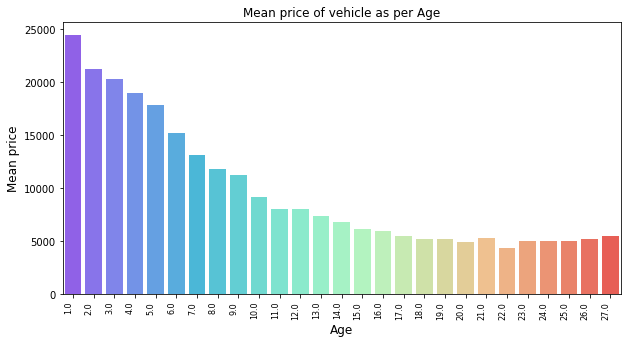

In [94]:
age_mean_price(replaced_null_vehicles_data)

#### 5.2) With Dropped null data

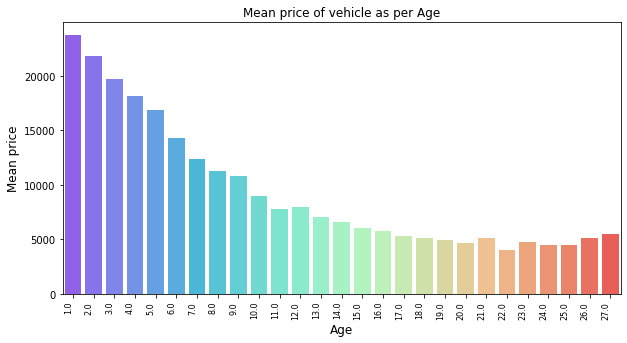

In [95]:
age_mean_price(dropped_null_vehicles_data)

##### Observation: We can observe that for the replaced data the range of the price is more than that of dropped data for every age

### 6.) Plot average odometer reading for each manufacturer

In [96]:
def avg_odometer(df):
    odometer_avg = df.groupby('manufacturer')['odometer'].mean().sort_values(ascending=False).reset_index()
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 6)
    plt.setp(ax.get_xticklabels(), rotation=90,fontsize=14)
    plt.setp(ax.get_yticklabels(),fontsize=12)
    sns.barplot(x='manufacturer',y='odometer',data=odometer_avg,palette='Paired')
    plt.show()


#### 6.1) With Replaced null data

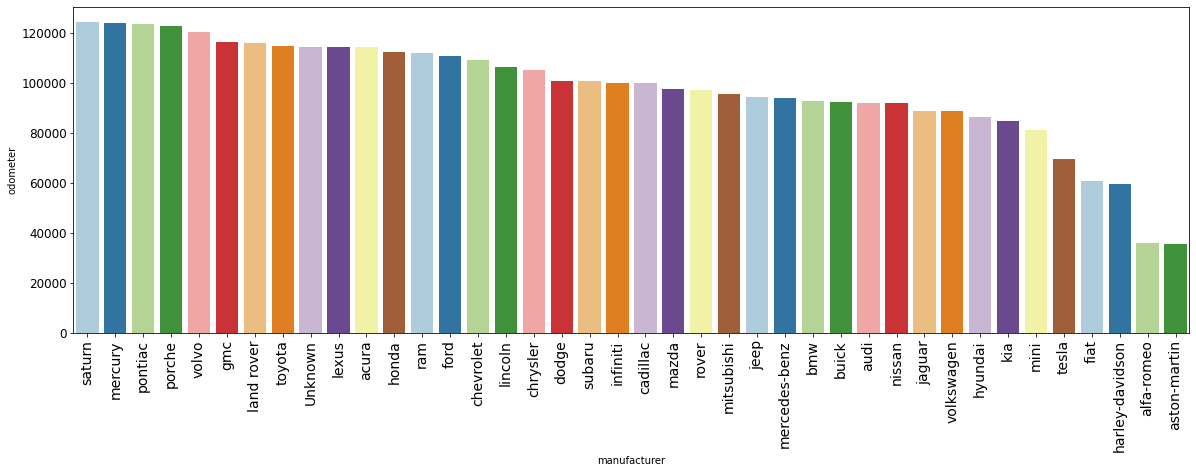

In [97]:
avg_odometer(replaced_null_vehicles_data)

#### 6.2) With Dropped null data

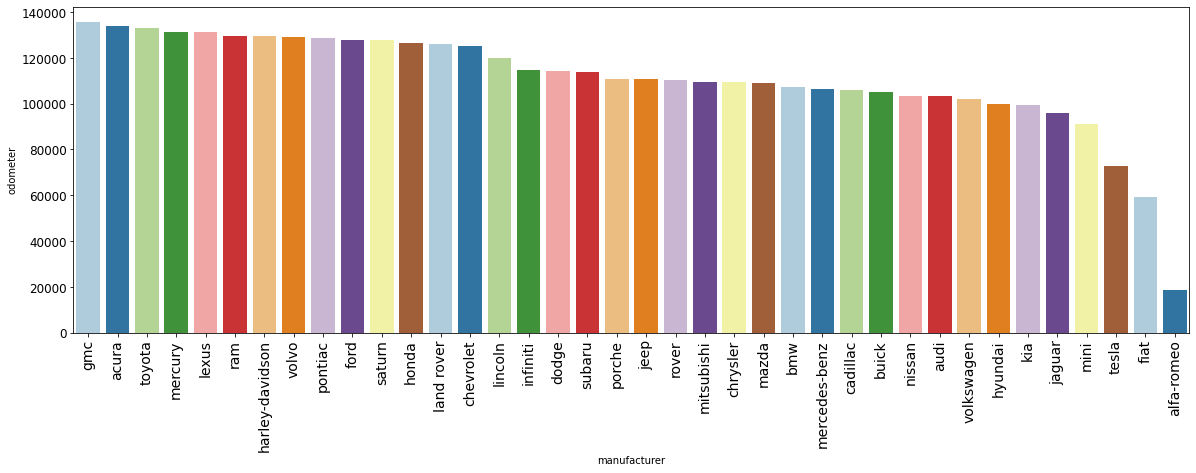

In [98]:
avg_odometer(dropped_null_vehicles_data)

##### Observation: There is a difference in the average odometer values for both replaced and dropped data. The max average value of odometer for replaced data is around 121k and for dropped data it is 138k 

## Scikit learn Machine Learning Model Building 

#### Now we are moving to predict the price using Scikit-Learn Supervised Regression Models for both the dataframes ( Replaced and Dropped)
#### Note: The score values mentioned in the report may change slightly depending on the system configurations

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import ensemble
from math import sqrt
import timeit

In [100]:
# Label encoding the categorical features to numerical
labelencoder = LabelEncoder()
columns = categorical_data

def label_columns(df, columns):
    ''' Labelling values in categorical columns with integers'''
    for i in range(len(columns)):
        df[columns[i]] = labelencoder.fit_transform(df[columns[i]])
        



In [101]:
# Replaced data label encoding
label_columns(replaced_null_vehicles_data, columns)


In [102]:
# Dropped data label encoding
label_columns(dropped_null_vehicles_data, columns)

In [103]:
# Checking the correlation between all the features and the label columns
def correlation_matrix(df):
    '''Shows correlation matrix of features in dataframe'''
    plt.figure(figsize = (20,5))
    corr = df.corr()
    sns.heatmap(corr, annot = True)
    plt.show()
    return corr
    
    

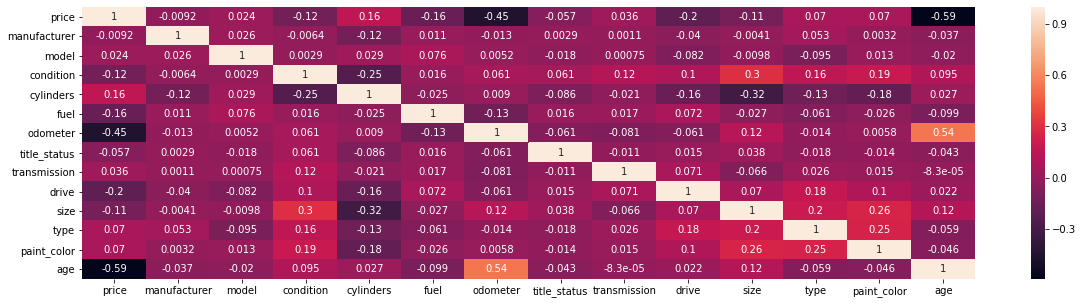

price  manufacturer     model  condition  cylinders  \
price         1.000000     -0.009192  0.023842  -0.124498   0.157074   
manufacturer -0.009192      1.000000  0.026316  -0.006448  -0.118538   
model         0.023842      0.026316  1.000000   0.002903   0.029468   
condition    -0.124498     -0.006448  0.002903   1.000000  -0.245211   
cylinders     0.157074     -0.118538  0.029468  -0.245211   1.000000   
fuel         -0.158689      0.011358  0.075885   0.015631  -0.025209   
odometer     -0.451848     -0.013016  0.005213   0.061261   0.009043   
title_status -0.057264      0.002942 -0.018085   0.060698  -0.086251   
transmission  0.036359      0.001068  0.000753   0.121135  -0.020814   
drive        -0.198821     -0.040296 -0.082344   0.099715  -0.160035   
size         -0.108723     -0.004063 -0.009814   0.299582  -0.315109   
type          0.070229      0.053271 -0.095435   0.156736  -0.131311   
paint_color   0.069850      0.003184  0.012646   0.192220  -0.183715   
age          -0.593843     -0.036910 -0.020198   0.095241   0.026864   

                  fuel  odometer  title_status  transmission     drive  \
price        -0.158689 -0.451848     -0.057264      0.036359 -0.198821   
manufacturer  0.011358 -0.013016      0.002942      0.001068 -0.040296   
model         0.075885  0.005213     -0.018085      0.000753 -0.082344   
condition     0.015631  0.061261      0.060698      0.121135  0.099715   
cylinders    -0.025209  0.009043     -0.086251     -0.020814 -0.160035   
fuel          1.000000 -0.128250      0.015553      0.017429  0.071930   
odometer     -0.128250  1.000000     -0.061043     -0.080782 -0.061098   
title_status  0.015553 -0.061043      1.000000     -0.011477  0.014686   
transmission  0.017429 -0.080782     -0.011477      1.000000  0.070629   
drive         0.071930 -0.061098      0.014686      0.070629  1.000000   
size         -0.027133  0.124284      0.038007     -0.066107  0.069936   
type         -0.060972 -0.013906     -0.018316      0.026018  0.182591   
paint_color  -0.026371  0.005767     -0.013514      0.014761  0.102392   
age          -0.098896  0.539286     -0.043365     -0.000083  0.022157   

                  size      type  paint_color       age  
price        -0.108723  0.070229     0.069850 -0.593843  
manufacturer -0.004063  0.053271     0.003184 -0.036910  
model        -0.009814 -0.095435     0.012646 -0.020198  
condition     0.299582  0.156736     0.192220  0.095241  
cylinders    -0.315109 -0.131311    -0.183715  0.026864  
fuel         -0.027133 -0.060972    -0.026371 -0.098896  
odometer      0.124284 -0.013906     0.005767  0.539286  
title_status  0.038007 -0.018316    -0.013514 -0.043365  
transmission -0.066107  0.026018     0.014761 -0.000083  
drive         0.069936  0.182591     0.102392  0.022157  
size          1.000000  0.200440     0.256241  0.118700  
type          0.200440  1.000000     0.247924 -0.059084  
paint_color   0.256241  0.247924     1.000000 -0.046257  
age           0.118700 -0.059084    -0.046257  1.000000

In [104]:
# Correlation values for replaced data
correlation_matrix(replaced_null_vehicles_data)

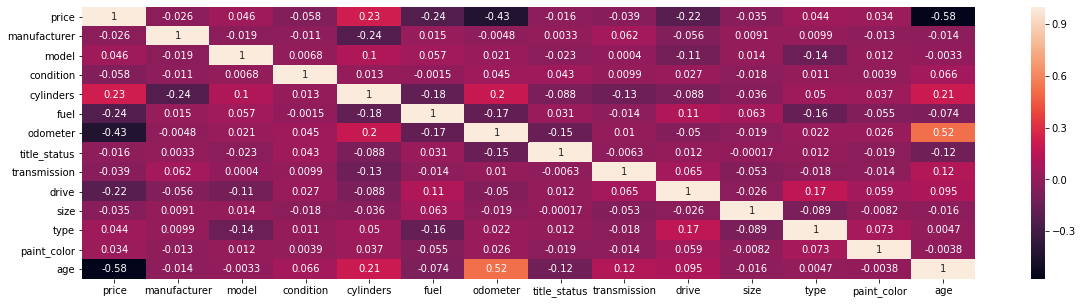

price  manufacturer     model  condition  cylinders  \
price         1.000000     -0.025751  0.045728  -0.058241   0.225262   
manufacturer -0.025751      1.000000 -0.019160  -0.011435  -0.236527   
model         0.045728     -0.019160  1.000000   0.006760   0.100935   
condition    -0.058241     -0.011435  0.006760   1.000000   0.013374   
cylinders     0.225262     -0.236527  0.100935   0.013374   1.000000   
fuel         -0.241812      0.015143  0.056732  -0.001498  -0.181129   
odometer     -0.434715     -0.004785  0.020941   0.045222   0.197773   
title_status -0.016035      0.003317 -0.023392   0.043335  -0.087833   
transmission -0.039470      0.061628  0.000396   0.009875  -0.131505   
drive        -0.215339     -0.056240 -0.106143   0.026853  -0.087616   
size         -0.035305      0.009123  0.014082  -0.018276  -0.035947   
type          0.043597      0.009917 -0.144145   0.011381   0.050386   
paint_color   0.034421     -0.012993  0.011910   0.003938   0.036653   
age          -0.577354     -0.014155 -0.003342   0.065538   0.206269   

                  fuel  odometer  title_status  transmission     drive  \
price        -0.241812 -0.434715     -0.016035     -0.039470 -0.215339   
manufacturer  0.015143 -0.004785      0.003317      0.061628 -0.056240   
model         0.056732  0.020941     -0.023392      0.000396 -0.106143   
condition    -0.001498  0.045222      0.043335      0.009875  0.026853   
cylinders    -0.181129  0.197773     -0.087833     -0.131505 -0.087616   
fuel          1.000000 -0.172171      0.031460     -0.014331  0.110975   
odometer     -0.172171  1.000000     -0.150181      0.010052 -0.049683   
title_status  0.031460 -0.150181      1.000000     -0.006295  0.011607   
transmission -0.014331  0.010052     -0.006295      1.000000  0.064970   
drive         0.110975 -0.049683      0.011607      0.064970  1.000000   
size          0.062996 -0.019241     -0.000174     -0.052958 -0.026085   
type         -0.161383  0.022241      0.011803     -0.018232  0.167398   
paint_color  -0.054938  0.025526     -0.018624     -0.013604  0.059114   
age          -0.074297  0.521429     -0.117430      0.115263  0.094613   

                  size      type  paint_color       age  
price        -0.035305  0.043597     0.034421 -0.577354  
manufacturer  0.009123  0.009917    -0.012993 -0.014155  
model         0.014082 -0.144145     0.011910 -0.003342  
condition    -0.018276  0.011381     0.003938  0.065538  
cylinders    -0.035947  0.050386     0.036653  0.206269  
fuel          0.062996 -0.161383    -0.054938 -0.074297  
odometer     -0.019241  0.022241     0.025526  0.521429  
title_status -0.000174  0.011803    -0.018624 -0.117430  
transmission -0.052958 -0.018232    -0.013604  0.115263  
drive        -0.026085  0.167398     0.059114  0.094613  
size          1.000000 -0.089134    -0.008235 -0.016322  
type         -0.089134  1.000000     0.073386  0.004654  
paint_color  -0.008235  0.073386     1.000000 -0.003759  
age          -0.016322  0.004654    -0.003759  1.000000

In [105]:
# Correlation values for dropped data
correlation_matrix(dropped_null_vehicles_data)

##### Observation: In both the dataframes , age is having max correlation with price

In [106]:
# Function for Model buliding

def model_building_sklearn(df, ml_algo, color):
    # training and testing a machine learning model
    
    #Defining Features(X) and label(y)
    X = df.iloc[:,1:]
    y = df['price']
    
    # Splitting the data into train and test 
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
    
    #Fitting the model on train data
    ml_algo.fit(X_train, y_train)
    
    #Predicting the performance on Train data
    predict_train = ml_algo.predict(X_train)
    
    # Getting the r2 score on train data
    train_score = ml_algo.score(X_train, y_train)
    
    #Predicting the model on test data
    predict_test = ml_algo.predict(X_test)
    
    #Getting the r2 score on test data
    test_score = ml_algo.score(X_test, y_test)
    
    # Evaluating actual and predicted results of test data
    prediction=pd.DataFrame(predict_test)
    prediction = prediction.head(n=100)
    
    # Printing the evaluation scores
    print('R2 Score on Train set is:', train_score)
    print('R2 Score on Test set is:', test_score)
    print('Root mean squared error on Train set is:', np.sqrt(mean_squared_error(y_train,predict_train)))
    print('Root mean squared error on Test set is:', np.sqrt(mean_squared_error(y_test, predict_test)))
    
  
    # plot actual price vs predicted price to visualize prediction on data
    plt.figure(figsize=(10,5))
    plt.scatter(x=y_test,y=predict_test, color=color)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.suptitle("Model Performance Score: %f" % test_score)
    plt.show()
    
    
    # plot actual price value and predicted price value for top 100 records
    test_index=y_test.reset_index()["price"]
    test_index = test_index.head(n=100)    
    ax=(test_index).plot(label="originals",figsize=(20,6),linewidth=1,color="r")
    ax=(prediction[0]).plot(label = "predictions",figsize=(20,6),linewidth=1,color="g")
    plt.legend(loc='upper right')
    plt.title("ORIGINALS VS PREDICTIONS for Top 100 Records")
    plt.xlabel("index")
    plt.ylabel("Price")
    plt.show()
    
    
    # plot how influential each feature is on machine learning model's prediction
    feat_importances = pd.Series(ml_algo.feature_importances_, index=df.columns[1:])
    feat_importances.plot(kind='bar',figsize=(10,5),color=color)
    plt.ylabel('Importance/Score')
    plt.xlabel('Features')
    plt.title('Feature Importances')
    plt.show()   
      

### Model building with Replaced null data & Dropped null data

### 1.) Decision Tree Regressor

#### 1.1.) With Replaced null data

R2 Score on Train set is: 0.7820738359676863
R2 Score on Test set is: 0.7311539319711343
Root mean squared error on Train set is: 4096.118016955368
Root mean squared error on Test set is: 4533.733294865538


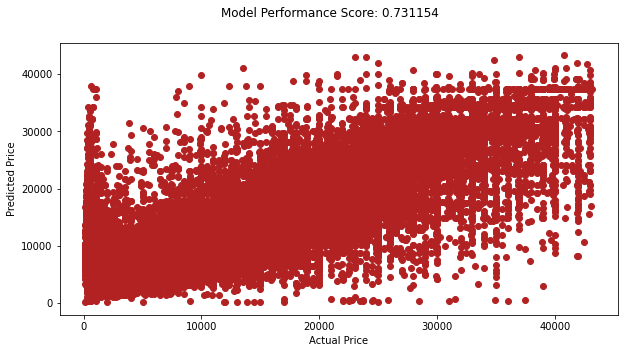

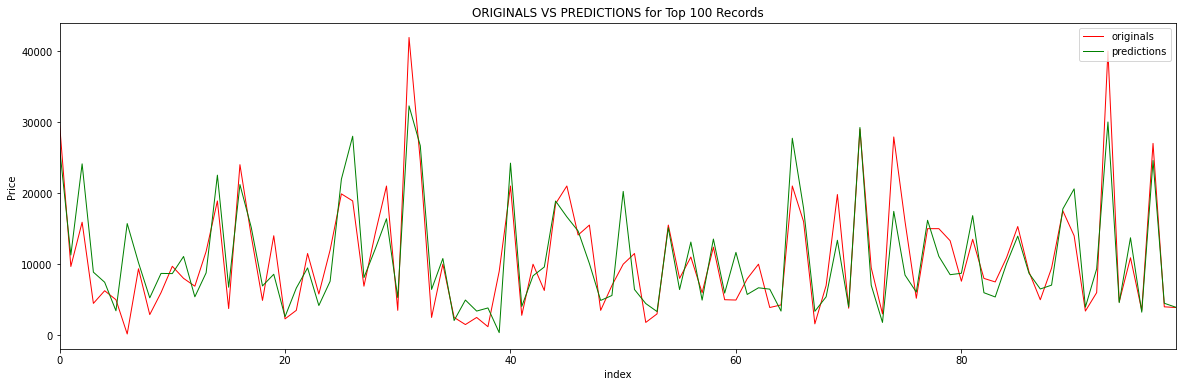

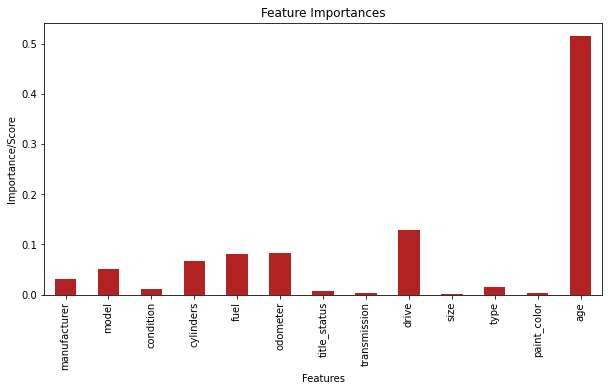

Wall time: 2.42 s


In [107]:
dt = DecisionTreeRegressor(max_depth=13)
%time model_building_sklearn(replaced_null_vehicles_data, dt, 'FireBrick')

#### 1.2.) With Dropped null data

R2 Score on Train set is: 0.815092118563182
R2 Score on Test set is: 0.7678336442738454
Root mean squared error on Train set is: 3253.8512581898144
Root mean squared error on Test set is: 3682.148122036581


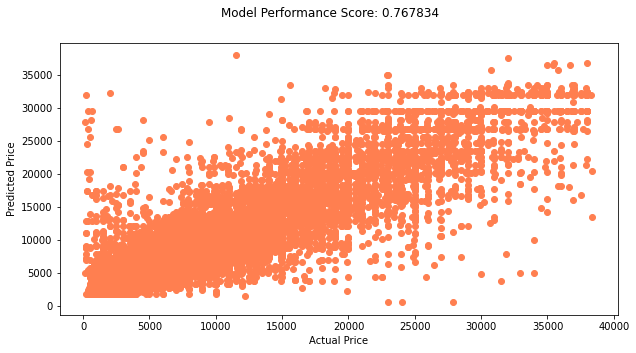

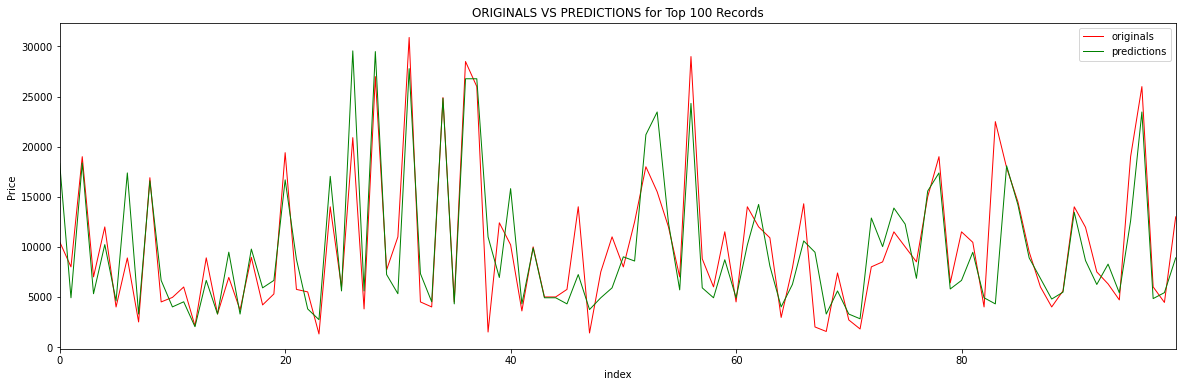

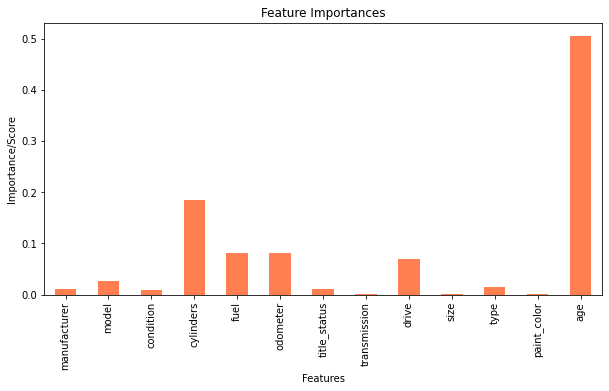

Wall time: 795 ms


In [108]:
dt = DecisionTreeRegressor(max_depth=10)
%time model_building_sklearn(dropped_null_vehicles_data, dt, 'Coral')

#### Observation : 
* R2 score of 0.78 is obtained on replaced data on train set and 0.72 on test set.
* R2 score of 0.81 is obtained on dropped data with train set and 0.76 on test set.
* The values are obtained after tuning the max depth and considering the optimal value of 13 for replaced data and 10 for dropped data. Dropped data is performing better than replaced data in predicting price as it has access to actual values in all features.

### 2.) Random Forest Regressor

#### 2.1.) With Replaced null data

R2 Score on Train set is: 0.8273322773292692
R2 Score on Test set is: 0.777940279264632
Root mean squared error on Train set is: 3644.0429282221708
Root mean squared error on Test set is: 4129.554284707442


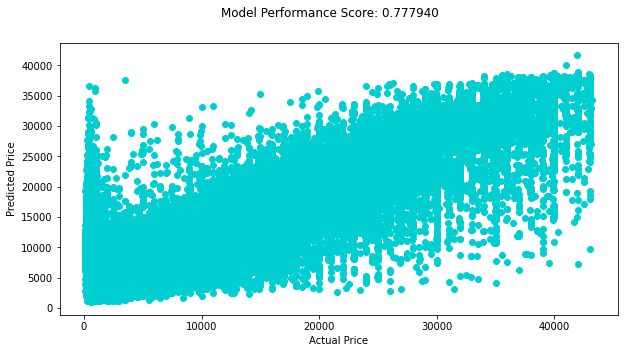

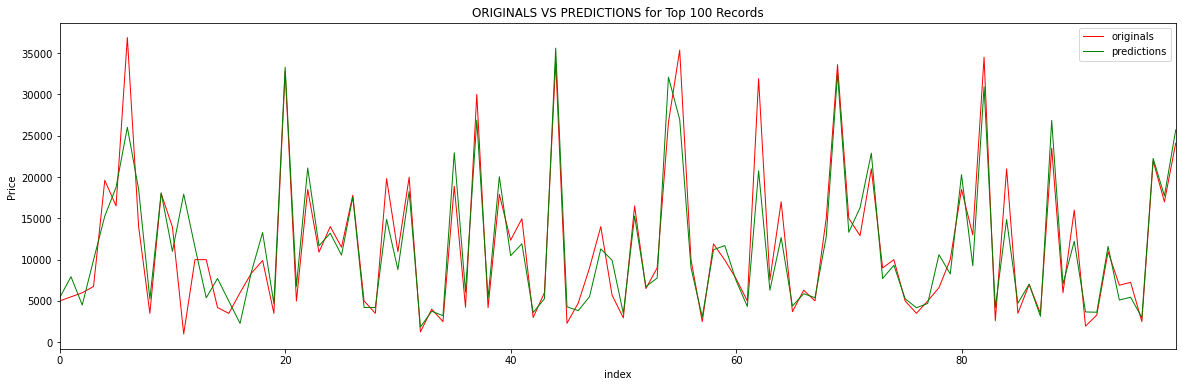

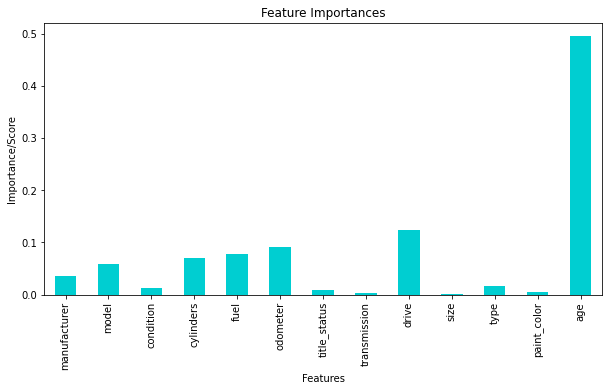

Wall time: 18.1 s


In [109]:
rf = RandomForestRegressor(n_estimators = 15, max_depth=14)
%time model_building_sklearn(replaced_null_vehicles_data, rf,'DarkTurquoise')


#### 2.2.) With Dropped null data

R2 Score on Train set is: 0.8791235737440631
R2 Score on Test set is: 0.8067818479731789
Root mean squared error on Train set is: 2648.353048755355
Root mean squared error on Test set is: 3269.7870817253533


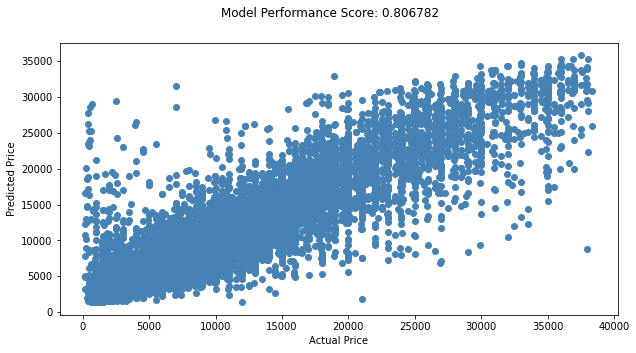

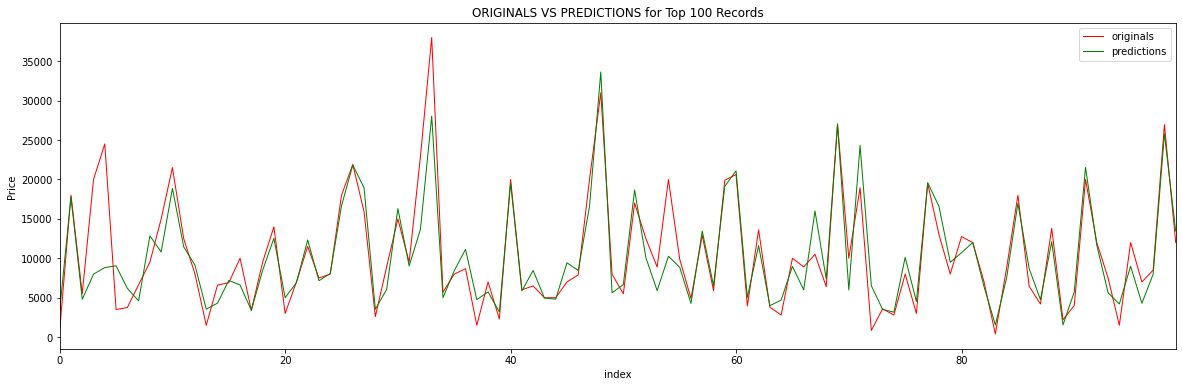

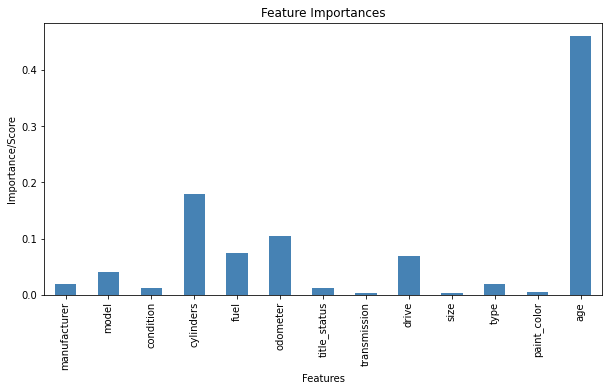

Wall time: 3.54 s


In [110]:
rf = RandomForestRegressor(n_estimators = 15, max_depth=12)
%time model_building_sklearn(dropped_null_vehicles_data, rf, 'SteelBlue')

##### Observation : 
* R2 score of 0.82 is obtained on replaced data on train set and 0.77 on test set.
* R2 score of 0.87 is obtained on dropped data with train set and 0.82 on test set.
* Thee values are obtained after tuning the max depth and n_estimators and considering the optimal values of 14 and 15 for replaced data and 12 and 15 for dropped data. 
* Dropped data is performing better than replaced data in predicting price as it has access to actual values in all features and also it learned by tuning the parameters.

* With the same estimators on both df's with max depth value 12 the dropped data is performing better than the replaced data because dropped data doesn't have unknown values.

###  3.) Gradient Boosting Regressor 

#### 3.1.) With Replaced null data

R2 Score on Train set is: 0.8568943697799185
R2 Score on Test set is: 0.8295772125584702
Root mean squared error on Train set is: 3317.6201873853765
Root mean squared error on Test set is: 3617.0181455694665


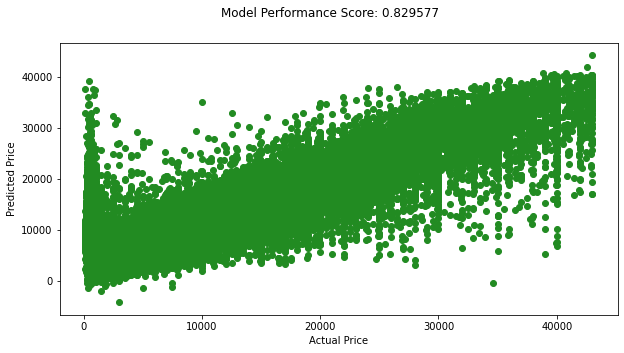

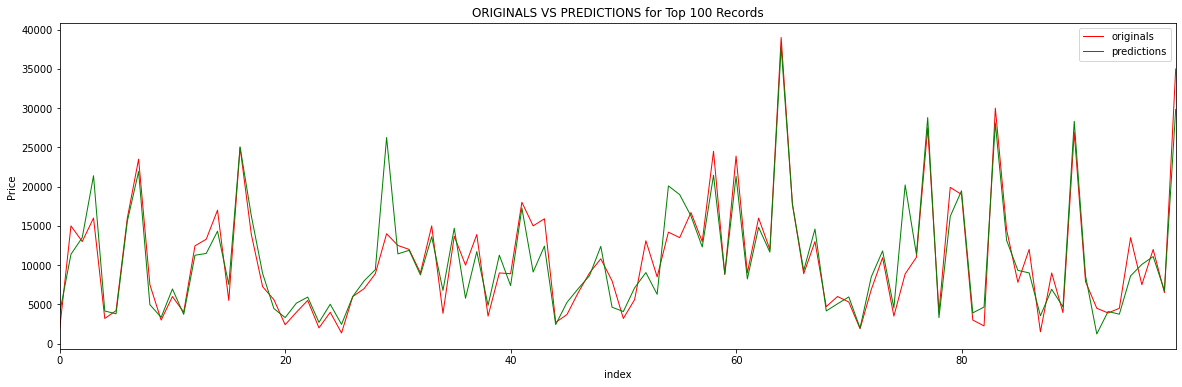

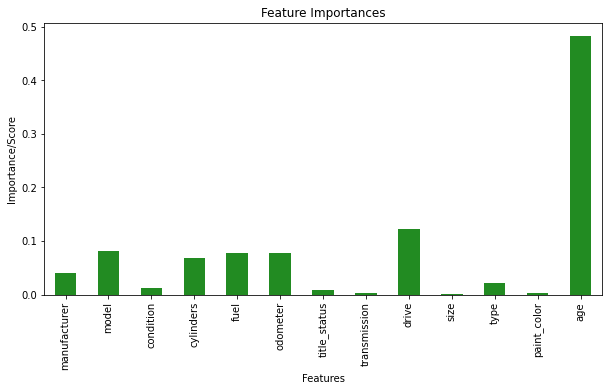

Wall time: 6min


In [111]:
gbt = GradientBoostingRegressor(n_estimators = 300, max_depth=7)
%time model_building_sklearn(replaced_null_vehicles_data,gbt, 'ForestGreen')


#### 3.2.) With Dropped null data

R2 Score on Train set is: 0.8992071850203224
R2 Score on Test set is: 0.8538271523013252
Root mean squared error on Train set is: 2410.6798499592055
Root mean squared error on Test set is: 2881.326114787815


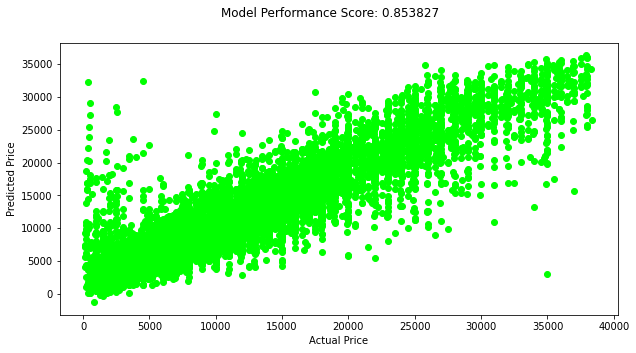

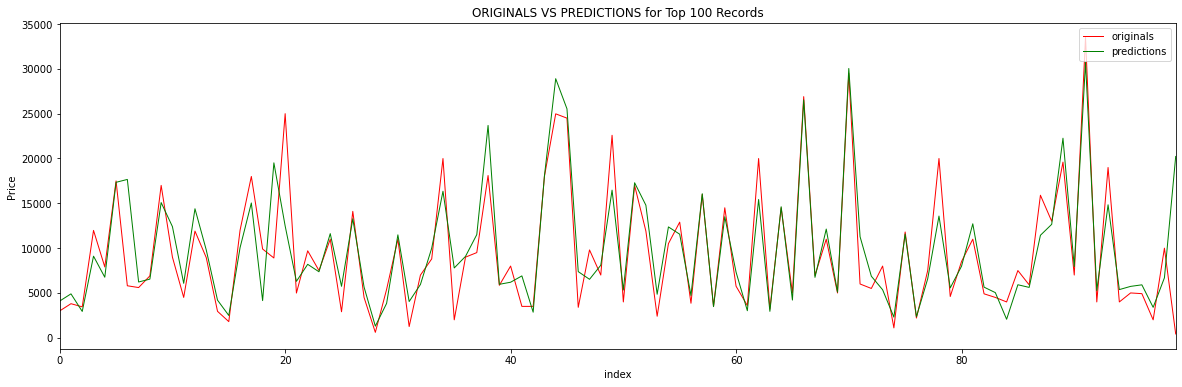

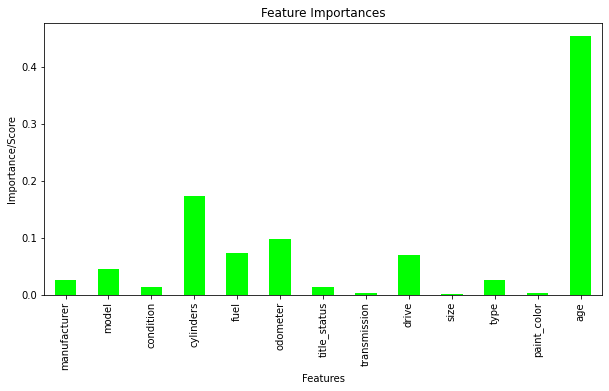

Wall time: 34.4 s


In [112]:
gbt = GradientBoostingRegressor(n_estimators = 180, max_depth=7)
%time model_building_sklearn(dropped_null_vehicles_data,gbt, 'Lime')

##### Observation: 
* Among all the model Gradient Boosting Regressor gave the best score for both replaced and dropped data. 
* It took 6min with replaced data with 300 estimators and depth of 7( train score:0.85, test_score:0.82 size:14.5mb) and 35s on dropped data with 180 estimators and depth as 7( train_data: 0.89, test_data:0.85 ,size:3.28mb). 
* GBR takes time as it learns from the wrongly predicted values in every iteration and corrects those mistakes.



In [113]:
# Converting pandas dataframes to csv for reading into pyspark
replaced_null_vehicles_data.to_csv('./replaced_null_vehicles_data.csv',index=False)
dropped_null_vehicles_data.to_csv('./dropped_null_vehicles_data.csv',index=False)


## Pyspark Machine Learning Model Building

#### We are using the Label encoded csv which is obtained from the pandas Dataframe
#### Note: The score values mentioned in the report may change slightly depending on the system configurations

In [114]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt


In [115]:
#Building a Spark Session
spark = SparkSession.builder \
.appName("Used Car Price Prediction") \
.getOrCreate()


In [116]:
#Reading the Data from dumped csv files 
replaced_null_sprk=spark.read.csv("./replaced_null_vehicles_data.csv", header='true', inferSchema = True)
dropped_null_sprk=spark.read.csv("./dropped_null_vehicles_data.csv", header='true', inferSchema = True)
replaced_null_sprk.printSchema()
dropped_null_sprk.printSchema()



root
 |-- price: integer (nullable = true)
 |-- manufacturer: integer (nullable = true)
 |-- model: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- cylinders: integer (nullable = true)
 |-- fuel: integer (nullable = true)
 |-- odometer: double (nullable = true)
 |-- title_status: integer (nullable = true)
 |-- transmission: integer (nullable = true)
 |-- drive: integer (nullable = true)
 |-- size: integer (nullable = true)
 |-- type: integer (nullable = true)
 |-- paint_color: integer (nullable = true)
 |-- age: double (nullable = true)

root
 |-- price: integer (nullable = true)
 |-- manufacturer: integer (nullable = true)
 |-- model: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- cylinders: integer (nullable = true)
 |-- fuel: integer (nullable = true)
 |-- odometer: double (nullable = true)
 |-- title_status: integer (nullable = true)
 |-- transmission: integer (nullable = true)
 |-- drive: integer (nullable = true)
 |-- size: integ

In [117]:
#Function for running Pyspark ML Supervised Regression Models
def model_building_pyspark(df,ml_algo,color):
    
    # Reading the Input features in the list 
    feature_list = []
    for col in df.columns:
        if col == 'price':
            continue
        else:
            feature_list.append(col)

    #Combining the input features into a dense vector
    assembler = VectorAssembler(inputCols=feature_list, outputCol="features")  
    combined_features_data = assembler.transform(df)
    
    #Combining Input features and labels and splitting the train and test data 
    combined_features_data = combined_features_data.select(['features', 'price'])
    train_df,test_df = combined_features_data.randomSplit([0.8, 0.2])   
    
    # Fitting the model on Train Data
    model=ml_algo.fit(train_df)
    
    #Predicting results on train data
    predictions_train = model.transform(train_df)
    
    #Predicting on test data
    predictions_test = model.transform(test_df)
    
    # Measuring the Models performance using Metrics
    evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
    r2score_train = evaluator.evaluate(predictions_train)
    r2score_test = evaluator.evaluate(predictions_test)
    
    print("R2 Score on train data = %g" % r2score_train)
    print("R2 Score on test data = %g" % r2score_test)
    
    # Storing the predictions for comparison with Actual Price 
    result = predictions_test.toPandas()
    prediction = result['prediction'].head(n=100)
    
    # Actual Price of cars for top 100 observations
    test_index=test_df.toPandas()
    test_index=test_index['price']
    test_index = test_index.head(n=100)   
    
    # plot actual price vs predicted price to visualize prediction on data
    plt.figure(figsize=(10,5))
    plt.scatter(x=result.price,y=result.prediction, color=color)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.suptitle("Model Performance R2 Score: %f" %r2score_test)
    plt.show()
    
   
    #Plotting the Original Price and Predicted Price of top 100 records
    ax=test_index.plot(label="originals",figsize=(20,6),linewidth=1,color="r")
    ax=prediction.plot(label = "predictions",figsize=(20,6),linewidth=1,color="g")
    plt.legend(loc='upper right')
    plt.title("ORIGINALS VS PREDICTIONS for Top 100 Records ")
    plt.xlabel("index")
    plt.ylabel("Price")
    plt.show()
    

   # Visualising Feature Importances of Input 
    importances = model.featureImportances
    x_values = list(range(len(importances)))
    plt.figure(figsize=(10,5))
    plt.bar(x_values, importances, orientation = 'vertical',color=color)
    plt.xticks(x_values, feature_list, rotation=90)
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Feature Importances')
    

### 1.) Decision Tree Regressor

#### 1.1) With Replaced null data

R2 Score on train data = 0.797698
R2 Score on test data = 0.736144


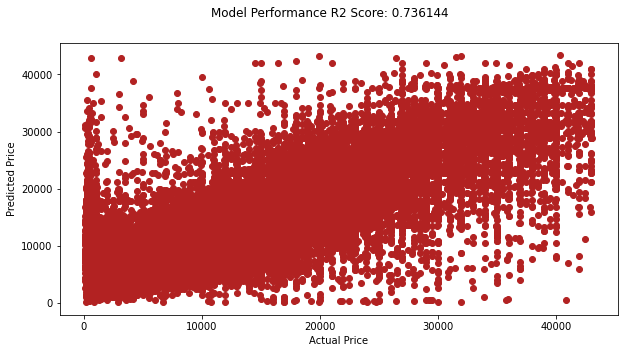

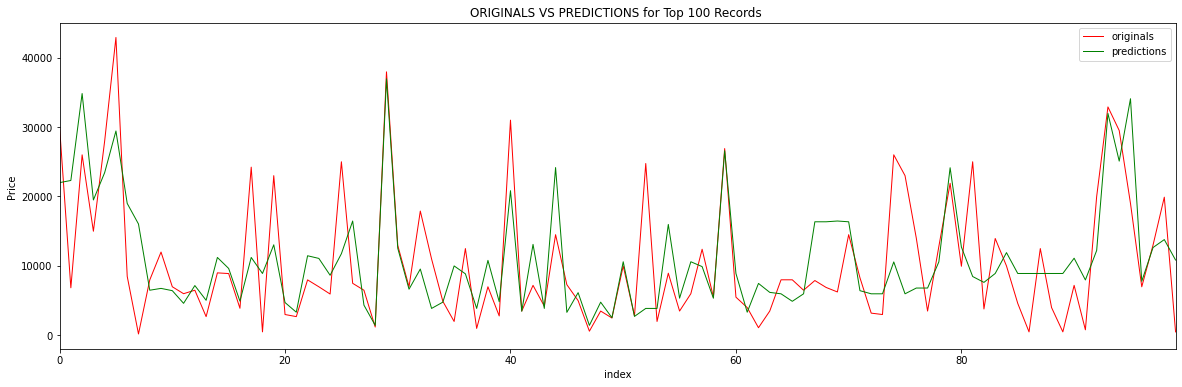

Wall time: 22 s


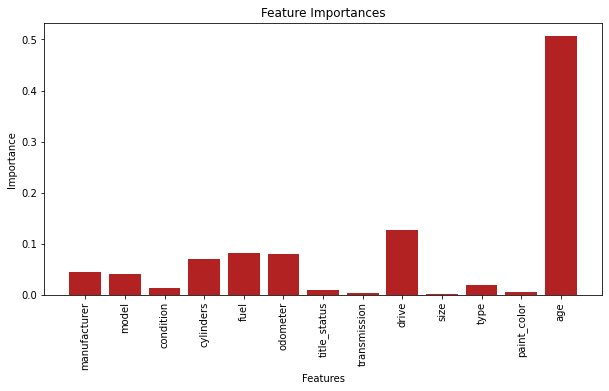

In [118]:
dt = DecisionTreeRegressor(labelCol="price", featuresCol="features",maxDepth=14)
%time model_building_pyspark(replaced_null_sprk, dt ,'FireBrick')

#### 1.1) With Dropped null  data

R2 Score on train data = 0.832176
R2 Score on test data = 0.774112


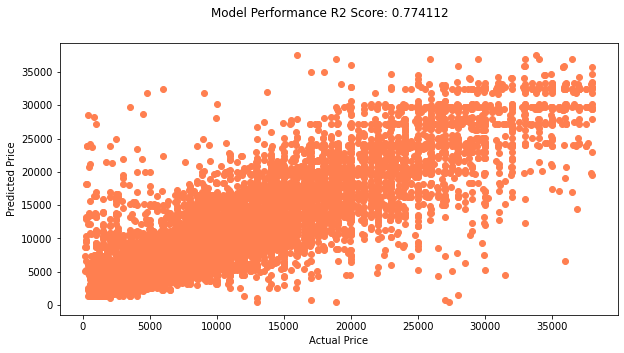

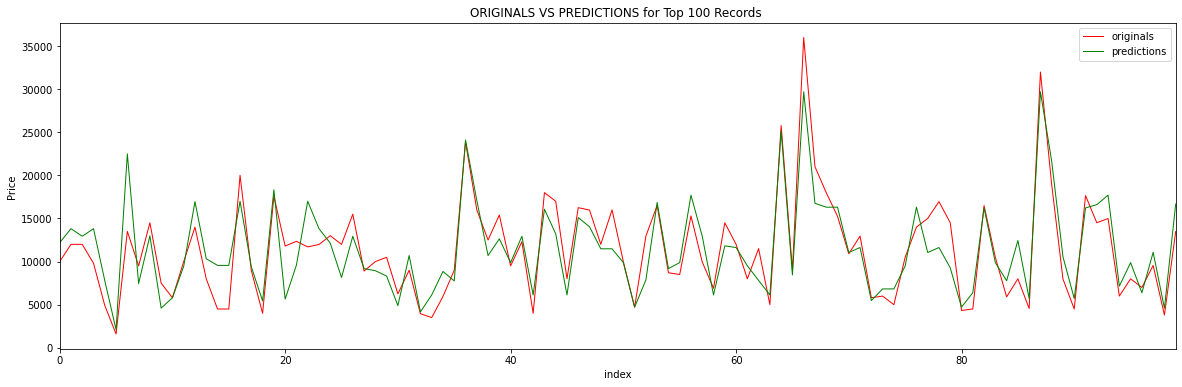

Wall time: 7.59 s


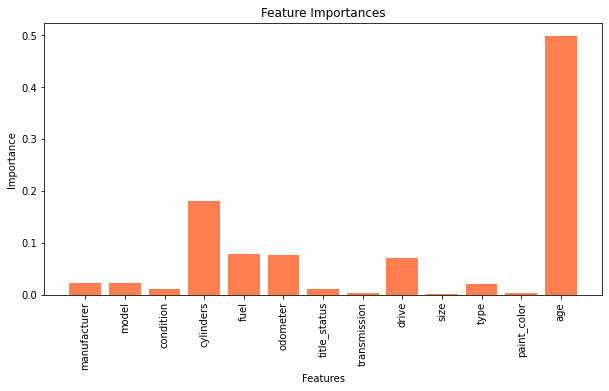

In [119]:
dt = DecisionTreeRegressor(labelCol="price", featuresCol="features",maxDepth=11)
%time model_building_pyspark(dropped_null_sprk, dt ,'Coral')

##### Observation: 
- dtreeparamGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [10,11,12,13,14,15,16])
             .addGrid(dt.maxBins, [10, 20,40,80])
             .build())
When tuned the model with above values in the cross validation,a depth of  11 is obtained for dropped data and 14 for replaced data.
##### R2 Scores on Replaced and Dropped
* Repalced Data 0.79(train),0.73(test)
* Dropped Data  0.83(train),0.77(test)

With less value of max_depth dropped data is giving good accuracy
             
 
    

### 2.) Random Forest

#### 2.1) Replaced null data

R2 Score on train data = 0.790929
R2 Score on test data = 0.760217


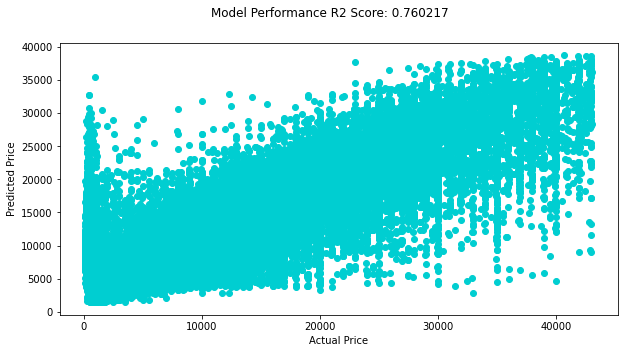

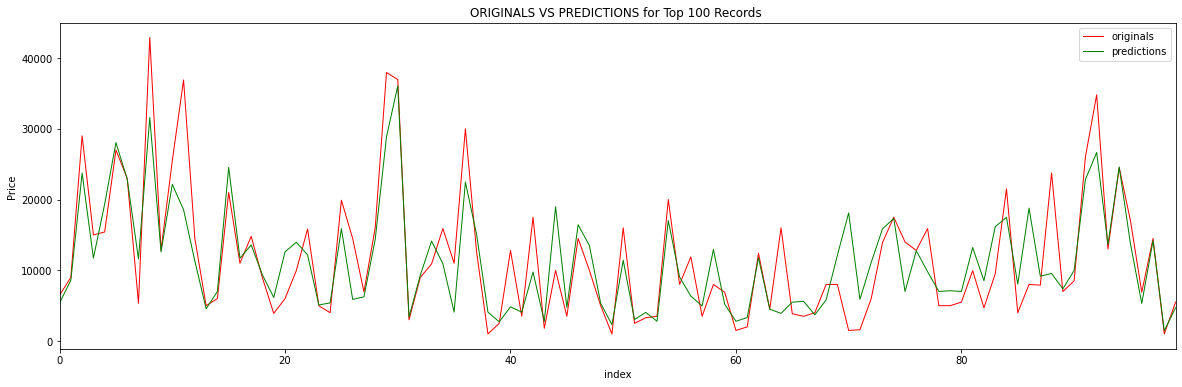

Wall time: 52.5 s


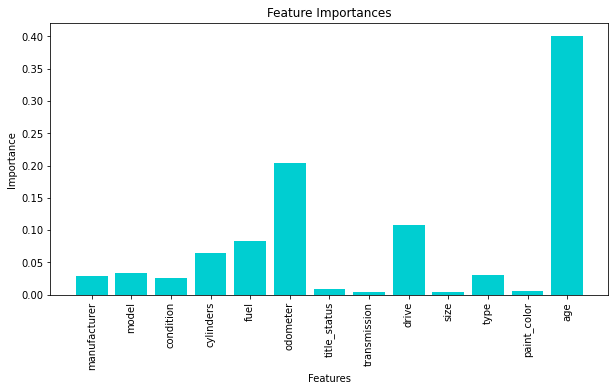

In [120]:
rf = RandomForestRegressor(labelCol="price", featuresCol="features", maxDepth=13, numTrees=20)
%time model_building_pyspark(replaced_null_sprk, rf ,'DarkTurquoise')


#### 2.2) With Dropped Null data

R2 Score on train data = 0.884281
R2 Score on test data = 0.824475


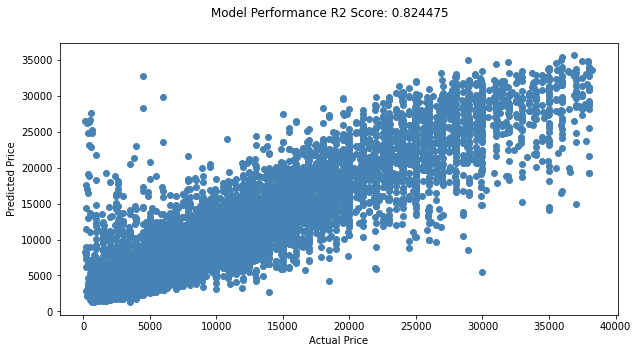

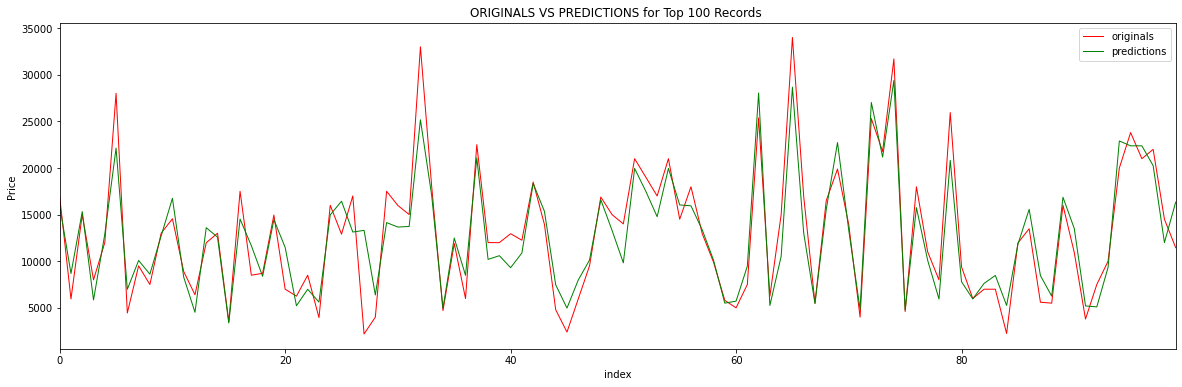

Wall time: 26.8 s


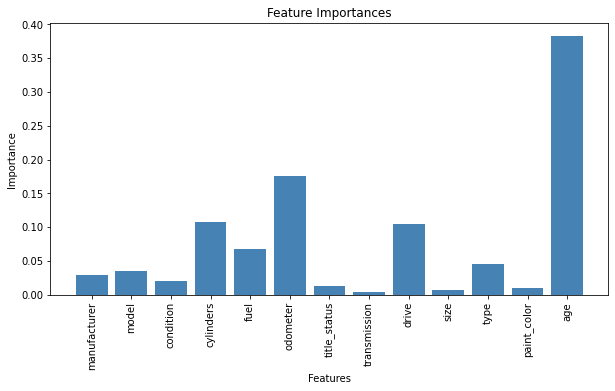

In [121]:
rf = RandomForestRegressor(labelCol="price", featuresCol="features", maxDepth=13, numTrees=20)
%time model_building_pyspark(dropped_null_sprk, rf ,'SteelBlue')


##### Observation:
- rfparamGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth,[11,12,13,14,15])
               .addGrid(rf.numTrees, [20,21,22,23,24])
               .build())

###### R2 Scores on Replaced and Dropped Data
When tuned the models with above parameter grid we got best scores with maxDepth :13 and numTrees:20 on both df's
R2 Scores:
* Replaced Data: 0.79(train),0.76 (test)
* Dropped Data: 0.88(train) , 0.82(test)

Getting more R2 score on dropped data with same parameters 



### 3.) Gradient Boosted Tree Regressor

#### 3.1) With Replaced Null Data

R2 Score on train data = 0.825677
R2 Score on test data = 0.80679


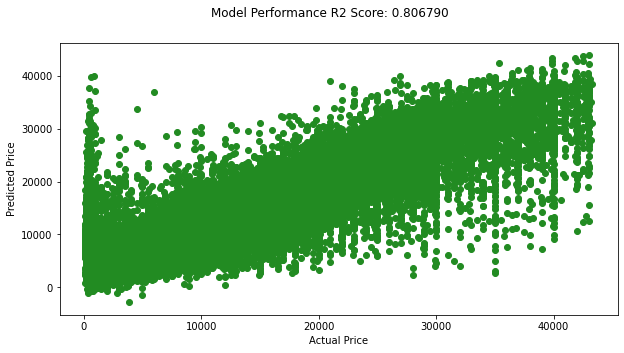

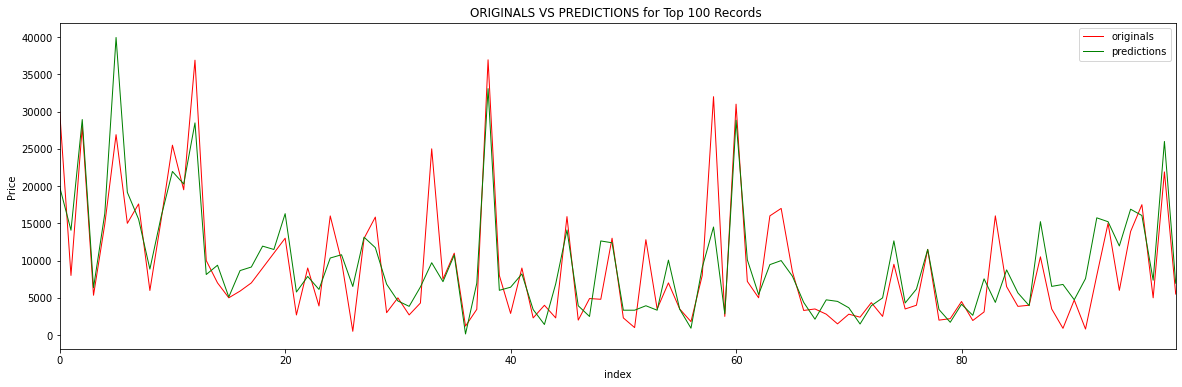

Wall time: 2min 56s


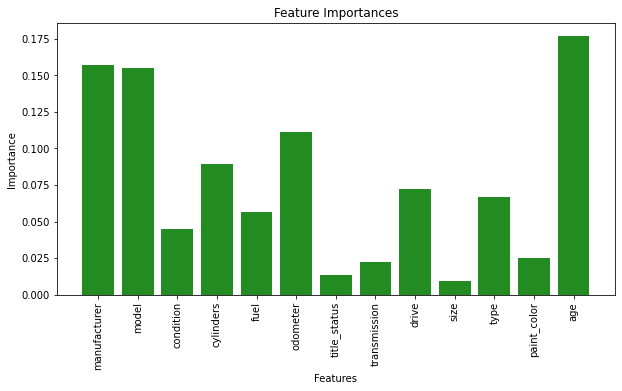

In [122]:
gbt = GBTRegressor(labelCol="price", featuresCol="features", maxIter=100, maxDepth=7)
%time model_building_pyspark(replaced_null_sprk, gbt ,'Forestgreen')

#### 3.2) With Dropped Null Data

R2 Score on train data = 0.865135
R2 Score on test data = 0.834188


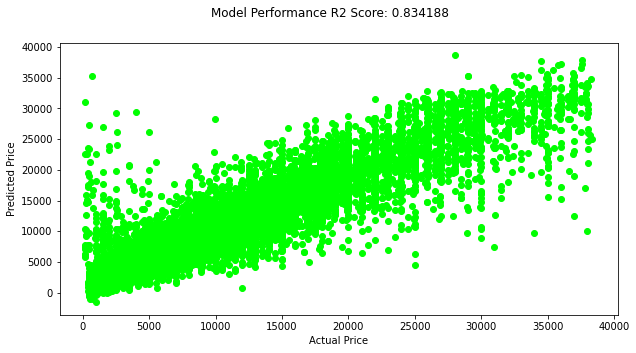

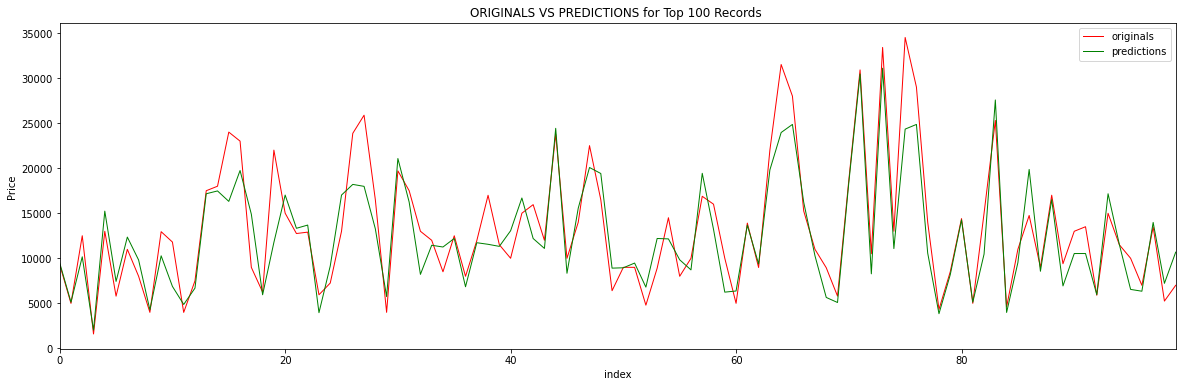

Wall time: 1min 17s


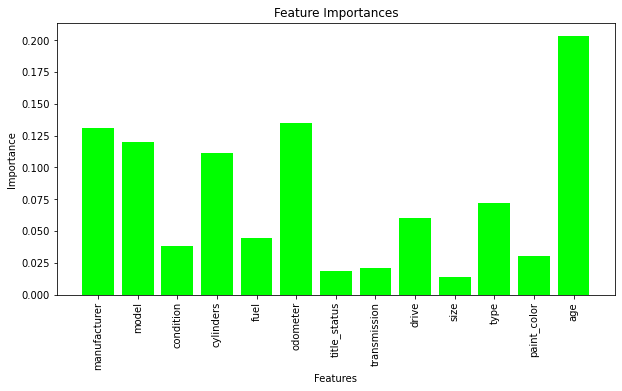

In [123]:
gbt = GBTRegressor(labelCol="price", featuresCol="features", maxIter=100, maxDepth=6)

%time model_building_pyspark(dropped_null_sprk, gbt ,'Lime')

##### Observation 

- paramGrid = ParamGridBuilder()\
          .addGrid(gbt.maxDepth, [4,5,6,7])\
          .addGrid(gbt.maxIter, [10,50,100])\
          .build()

When tuned with the above parameters the for dropped data with a depth of 6 and maxIter 100 it gave good score than replaced data with depth 7 and max iter 100
##### R2 Scores on Replaced and dropped
* Replaced data 0.82(train),0.80(test)
* Dropped Data 0.86(train) ,0.83(test)

The time GBT took for Dropped data is 2 min and Replaced data is 4min 45 s with best parameters

### Replaced Dataset predicted score comparison (Pyspark vs Sklearn)

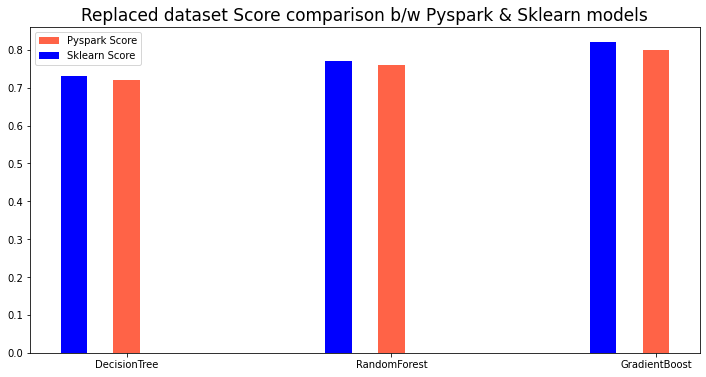

In [124]:
# Models scores on test data
pyspark={"DecisionTree":0.72,"RandomForest":0.76,"GradientBoost":0.80}
sklearn={"DecisionTree":0.73,"RandomForest":0.77,"GradientBoost":0.82}
X = np.arange(len(pyspark))
plt.figure(figsize=(12,6))
ax = plt.subplot(111)
ax.bar(X, pyspark.values(), width=0.1, color='tomato', align='center')
ax.bar(X-0.2, sklearn.values(), width=0.1, color='blue', align='center')
ax.legend(('Pyspark Score','Sklearn Score'))
plt.xticks(X, pyspark.keys())
plt.title("Replaced dataset Score comparison b/w Pyspark & Sklearn models", fontsize=17)
plt.show()

### Dropped Dataset predicted score comparison (Pyspark vs Sklearn)

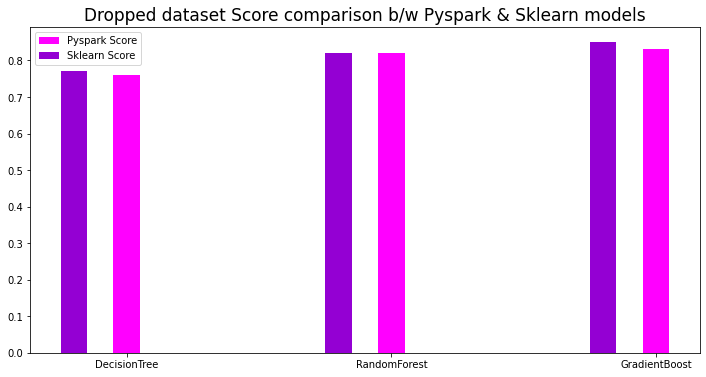

In [125]:
# Models score on test data
pyspark={"DecisionTree":0.76,"RandomForest":0.82,"GradientBoost":0.83}
sklearn={"DecisionTree":0.77,"RandomForest":0.82,"GradientBoost":0.85}
X = np.arange(len(pyspark))
plt.figure(figsize=(12,6))
ax = plt.subplot(111)
ax.bar(X, pyspark.values(), width=0.1, color='magenta', align='center')
ax.bar(X-0.2, sklearn.values(), width=0.1, color='Darkviolet', align='center')
plt.legend(('Pyspark Score','Sklearn Score'))
plt.xticks(X, pyspark.keys())
plt.title("Dropped dataset Score comparison b/w Pyspark & Sklearn models", fontsize=17)
plt.show()

### Conclusion 
On overall when the models are compared in both Scikit learn and Pyspark , Scikit-Learn's individual models performed better when compared to PysparkML. Pyspark is more useful when the data is large and we can take an advantage of parallel processing .Pyspark uses vectorization which makes processes faster we observed this on GBT model where same dataframe took lesser time than Sklearn GBT Model.